https://mp.weixin.qq.com/s/X_LSll_u-KmD4Wd2Se9LWA
    
https://github.com/chiphuyen/machine-learning-systems-design

# 系统设计
这个词对于我而言，一直有很大的魔力。

系统，我的理解，就是一个(组)tasks闭环，接收一些指定格式的输入和参数设置，然后就可以一直运行到任务终结

# Machine Learning Systems Design
第二部分是这本书的核心内容，即如何设计一个机器学习系统。作者将这一设计过程分为四步：项目设置、数据 pipeline、建模（选择、训练和调试模型）和服务（测试、部署和维护模型）。

This booklet covers four main steps of designing a machine learning system:
* Project setup
* Data pipeline
* Modeling: selecting, training, and debugging
* Serving: testing, deploying, and maintaining

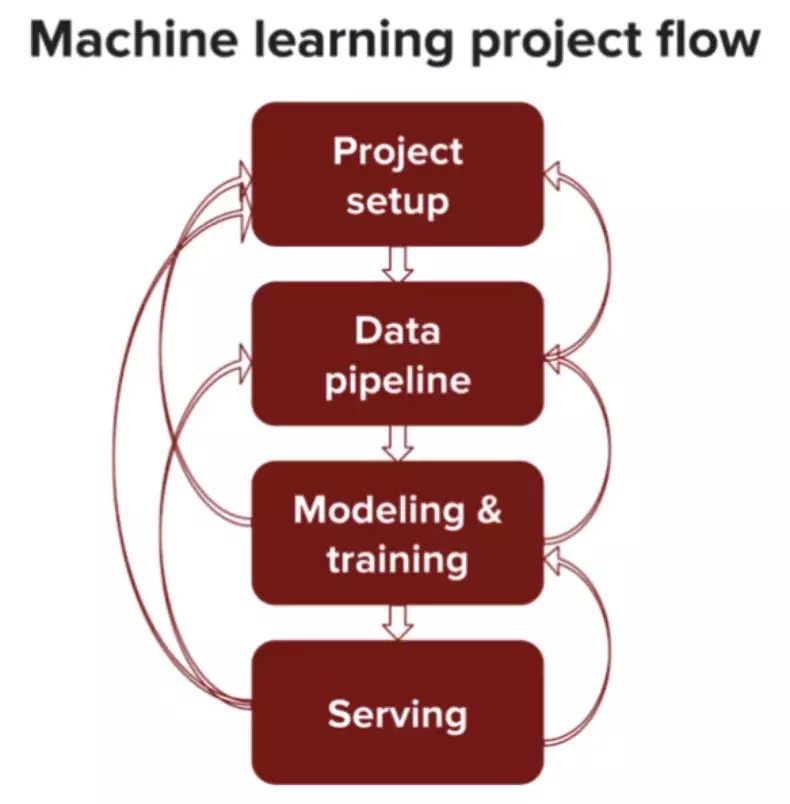

# SparkML框架解析
http://spark.apache.org/docs/latest/ml-pipeline.html

## Main concepts in Pipelines

MLlib standardizes APIs for machine learning algorithms to make it easier to combine multiple algorithms into a single pipeline, or workflow. This section covers the key concepts introduced by the Pipelines API, where the pipeline concept is mostly inspired by the scikit-learn project.

* __DataFrame__: ml使用的数据结构。This ML API uses DataFrame from Spark SQL as an ML dataset, which can hold a variety of data types. E.g., a DataFrame could have different columns storing text, feature vectors, true labels, and predictions.

* __Transformer__: 输入一个df，输出另外一个df。A Transformer is an algorithm which can transform one DataFrame into another DataFrame. E.g., an ML model is a Transformer which transforms a DataFrame with features into a DataFrame with predictions.   
Technically, a Transformer implements a method `transform()`, which converts one DataFrame into another  
transformer包含两类：
    * feature transformers
    * learned models

* __Estimator__: fit一个df，输出一个__Transformer__。An Estimator is an algorithm which can be fit on a DataFrame to produce a Transformer. E.g., a learning algorithm is an Estimator which trains on a DataFrame and produces a model.

* __Pipeline__: A Pipeline chains multiple Transformers and Estimators together to specify an ML workflow.

* __Parameter__: All Transformers and Estimators now share a common API for specifying parameters.


__Transformer.transform()s and Estimator.fit()s are both stateless__. 

__Each instance of a Transformer or Estimator has a unique ID, which is useful in specifying parameters__

## How it works

A Pipeline is specified as __a sequence of stages__, and each stage is either a Transformer or an Estimator. These stages are run __in order__, and the input DataFrame is transformed as it passes through each stage. For Transformer stages, the transform() method is called on the DataFrame. For Estimator stages, the fit() method is called to produce a Transformer (which becomes part of the PipelineModel, or fitted Pipeline), and that Transformer’s transform() method is called on the DataFrame.

We illustrate this for the simple text document workflow. The figure below is for the training time usage of a Pipeline.
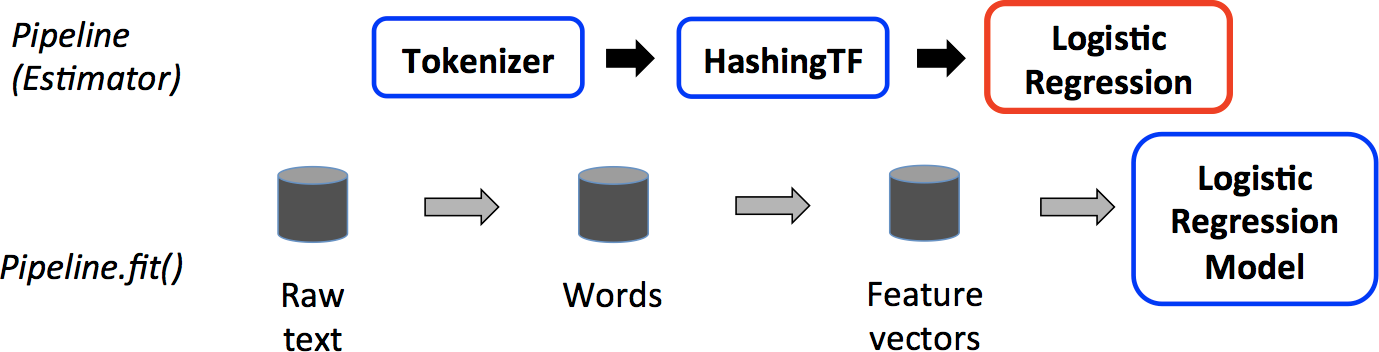

A Pipeline is an Estimator. Thus, after a Pipeline’s fit() method runs, it produces a PipelineModel, which is a Transformer. This PipelineModel is used at test time; the figure below illustrates this usage.
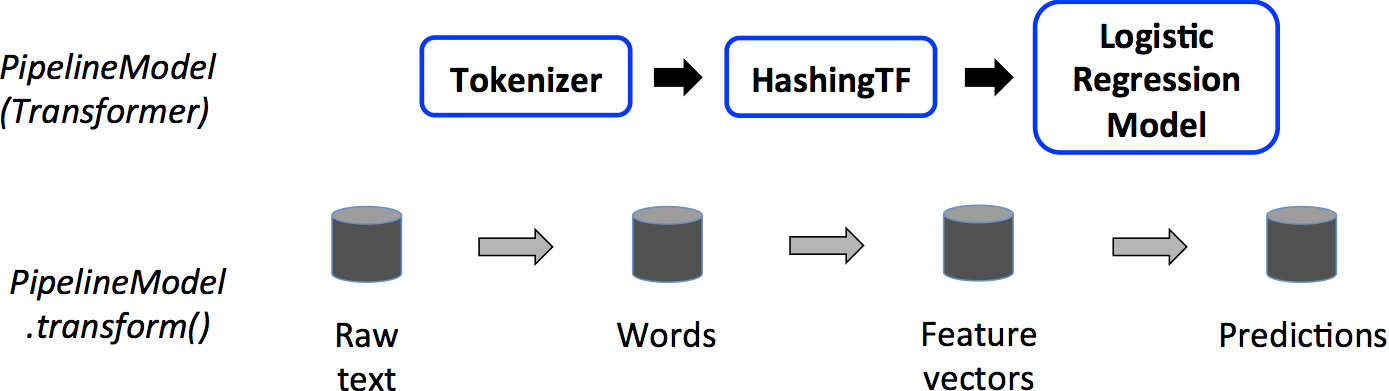


Pipelines and PipelineModels help to ensure that training and test data go through identical feature processing steps.
Details

### Details

DAG Pipelines: A Pipeline’s stages are specified as an ordered array. The examples given here are all for linear Pipelines, i.e., Pipelines in which each stage uses data produced by the previous stage. It is possible to create non-linear Pipelines as long as the data flow graph forms a Directed Acyclic Graph (DAG). This graph is currently specified implicitly based on the input and output column names of each stage (generally specified as parameters). If the Pipeline forms a DAG, then the stages must be specified in topological order.

## 示例

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import HashingTF, Tokenizer

# Prepare training documents from a list of (id, text, label) tuples.
training = spark.createDataFrame([
    (0, "a b c d e spark", 1.0),
    (1, "b d", 0.0),
    (2, "spark f g h", 1.0),
    (3, "hadoop mapreduce", 0.0)
], ["id", "text", "label"])

# Configure an ML pipeline, which consists of three stages: tokenizer, hashingTF, and lr.
tokenizer = Tokenizer(inputCol="text", outputCol="words")
hashingTF = HashingTF(inputCol=tokenizer.getOutputCol(), outputCol="features")
lr = LogisticRegression(maxIter=10, regParam=0.001)
pipeline = Pipeline(stages=[tokenizer, hashingTF, lr])

# Fit the pipeline to training documents.
model = pipeline.fit(training)

# Prepare test documents, which are unlabeled (id, text) tuples.
test = spark.createDataFrame([
    (4, "spark i j k"),
    (5, "l m n"),
    (6, "spark hadoop spark"),
    (7, "apache hadoop")
], ["id", "text"])

# Make predictions on test documents and print columns of interest.
prediction = model.transform(test)
selected = prediction.select("id", "text", "probability", "prediction")
for row in selected.collect():
    rid, text, prob, prediction = row
    print("(%d, %s) --> prob=%s, prediction=%f" % (rid, text, str(prob), prediction))

# sklearn中的pipeline
https://scikit-learn.org/stable/modules/compose.html

Pipeline can be used to chain multiple estimators into one. This is useful as there is often a fixed sequence of steps in processing the data, for example feature selection, normalization and classification. Pipeline serves multiple purposes here:

* Convenience and encapsulation  
    You only have to call fit and predict once on your data to fit a whole sequence of estimators.
* Joint parameter selection  
    You can grid search over parameters of all estimators in the pipeline at once.
* Safety  
    Pipelines help avoid leaking statistics from your test data into the trained model in cross-validation, by ensuring that the same samples are used to train the transformers and predictors.

All estimators in a pipeline, except the last one, must be transformers (i.e. must have a transform method). The last estimator may be any type (transformer, classifier, etc.).

## Usage
### Construction

The Pipeline is built using a list of (key, value) pairs, where the key is a string containing the name you want to give this step and value is an estimator object:



In [2]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.decomposition import PCA
estimators = [('reduce_dim', PCA()), ('clf', SVC())]
pipe = Pipeline(estimators)
pipe 

/Users/luoyonggui/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/Users/luoyonggui/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


Pipeline(memory=None,
         steps=[('reduce_dim',
                 PCA(copy=True, iterated_power='auto', n_components=None,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('clf',
                 SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3,
                     gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                     probability=False, random_state=None, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

The utility function make_pipeline is a shorthand for constructing pipelines; it takes a variable number of estimators and returns a pipeline, filling in the names automatically:

In [3]:
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import Binarizer
make_pipeline(Binarizer(), MultinomialNB()) 

Pipeline(memory=None,
         steps=[('binarizer', Binarizer(copy=True, threshold=0.0)),
                ('multinomialnb',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

### Accessing steps

The estimators of a pipeline are stored as a list in the steps attribute, but can be accessed by index or name by indexing (with [idx]) the Pipeline:

In [4]:
pipe.steps[0] 

('reduce_dim',
 PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
     svd_solver='auto', tol=0.0, whiten=False))

In [5]:
pipe[0] 

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [6]:
pipe['reduce_dim']

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

### Notes

Calling fit on the pipeline is the same as calling fit on each estimator in turn, transform the input and pass it on to the next step. 

The pipeline has all the methods that the last estimator in the pipeline has, i.e. if the last estimator is a classifier, the Pipeline can be used as a classifier. If the last estimator is a transformer, again, so is the pipeline.